In [ ]:
!pip install torchsummary

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import os
from torchsummary import summary
import random
from tqdm.notebook import tqdm
import cv2
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
d = {}
files_ = os.listdir("/content/gdrive/My Drive/vqvae/latent_data/")
files = []
for i in files_:
  if (i.split("_")[0] == "BANDED BROADBILL"):
    files.append("/content/gdrive/My Drive/vqvae/latent_data/"+i)

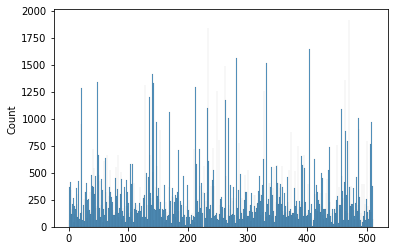

In [ ]:
classes = []
for i in files:
  rep = np.load(i)[:,0]
  classes.extend(rep)
import collections
counter=collections.Counter(list(classes))
counter = dict(counter)
sns.histplot(data=np.array(classes),bins=512)

In [ ]:
weights = [0]*512
for i in range(512):
    try:
      weights[i] = 1/counter[i]
    except:
      pass
average = sum(weights)/512
for i in range(512):
    if weights[i] == 0:
      weights[i] = average
weights = torch.tensor(weights)

In [ ]:
class PriorDataset(Dataset):
    def __init__(self, root_dir, codebook):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        self.files = []
        for i in self.list_files:
            if (i.split("_")[0] == "BANDED BROADBILL"):
                self.files.append(i)
        self.files = [self.root_dir + "/" + f for f in self.files]
        self.codebook = codebook
        self.codebook_dims = self.codebook.shape[-1]
        print("{} files found for training".format(len(self.files)))
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        rep = np.load(file)[:,0]
        Y = torch.tensor(rep)
        rep = np.concatenate([np.asarray(512).reshape(1),rep], axis=0)
        X = torch.tensor(rep[:-1])
        return X,Y

In [ ]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        if self.weight is not None:
            ce_loss = F.cross_entropy(input, target, reduction=self.reduction, weight=self.weight)
        else:
            ce_loss = F.cross_entropy(input, target, reduction=self.reduction)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
%%capture
#model
class GPTconfig:
    def __init__(self, vocab_size, embedding_dim, num_layers, num_heads, max_size,
                 attn_drop, res_drop,
                 device):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.max_size = max_size
        self.attn_drop = attn_drop
        self.res_drop = res_drop
        self.device = device

class selfAttention(nn.Module):
    def __init__(self, config):
        super(selfAttention, self).__init__()

        self.key_layer = nn.Linear(config.embedding_dim, config.embedding_dim)
        self.query_layer = nn.Linear(config.embedding_dim, config.embedding_dim)
        self.value_layer = nn.Linear(config.embedding_dim, config.embedding_dim)

        self.attn_dropout = nn.Dropout(config.attn_drop)
        self.res_dropout = nn.Dropout(config.res_drop)

        self.mlp = nn.Linear(config.embedding_dim, config.embedding_dim)
        
        self.register_buffer("mask", torch.tril(torch.ones(config.max_size, config.max_size))
                                     .view(1, 1, config.max_size, config.max_size))
        self.n_heads = config.num_heads

    def forward(self, X):
        B, T, C = X.size()
        k = self.key_layer(X).view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)
        v = self.value_layer(X).view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)
        q = self.query_layer(X).view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)

        att = (q @ k.transpose(-2, -1))*(1/k.size(-1)**0.5)
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))

        att = F.softmax(att, dim = -1)
        att = self.attn_dropout(att)
        
        transformed = att @ v
        transformed = transformed.transpose(1,2).contiguous().view(B,T,C)
        transformed = self.mlp(transformed)
        transformed = self.res_dropout(transformed)
        return transformed


class buildingBlock(nn.Module):
    def __init__(self, config):
        super(buildingBlock, self).__init__()
        
        self.layernorm1 = nn.LayerNorm(config.embedding_dim)
        self.layernorm2 = nn.LayerNorm(config.embedding_dim)

        self.attention_layer = selfAttention(config)

        self.mlp = nn.Sequential(
            nn.Linear(config.embedding_dim, 4 * config.embedding_dim),
            nn.GELU(),
            nn.Linear(4 * config.embedding_dim, config.embedding_dim),
            nn.Dropout(config.res_drop),
        )

    def forward(self, X):
        X = X + self.attention_layer(self.layernorm1(X))
        X = X + self.mlp(self.layernorm2(X))
        return X

class GPT(nn.Module):
    def __init__(self, config):
        super(GPT, self).__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, config.max_size, config.embedding_dim))
        self.embedding_layer = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.drop = nn.Dropout(config.res_drop)
        self.focal_loss = FocalLoss()
        self.blocks = nn.Sequential(*[buildingBlock(config) for i in range(config.num_layers)])

        self.layernorm = nn.LayerNorm(config.embedding_dim)
        self.mlp = nn.Linear(config.embedding_dim, config.vocab_size-1)
        self.to(config.device)
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, X, y=None):
        b, t = X.size()
        X = self.embedding_layer(X)
        pos_embed = self.pos_embedding[:,:t,:]
        X = self.drop(pos_embed+X)
        X = self.blocks(X)
        X = self.layernorm(X)
        logits = self.mlp(X)
        if y is not None:
            loss = self.focal_loss(logits.view(-1, logits.size(-1)), y.view(-1))
        else:
            loss = 0

        return logits, loss


class Decoder(nn.Module):
    
    def __init__(self, stride = 2):
        super(Decoder, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode = 'bilinear')
        self.upsample1 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)
        self.upsample3 = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
        self.conv1 = ResidualStack(128, 64, 256,2)
        self.conv2 = ResidualStack(64, 32, 128,3)
        self.conv3 = ResidualStack(32, 16, 64,3)
        self.conv4 = ResidualStack(16, 8, 32,3)
        self.conv5 = nn.Conv2d(8, 3, kernel_size=1,
                      stride=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,X):
        X = self.conv1(X) 
        X = self.upsample1(X, output_size=(X.size(0),X.size(1),X.size(2)*2,X.size(3)*2))        #56
        X = self.conv2(X) 
        X = self.upsample2(X, output_size=(X.size(0),X.size(1),X.size(2)*2,X.size(3)*2))       #112
        X = self.conv3(X)
        X = self.upsample3(X, output_size=(X.size(0),X.size(1),X.size(2)*2,X.size(3)*2))       #224
        X = self.conv4(X)
        X = self.conv5(X)
        return self.sigmoid(X)


class ResidualLayer(nn.Module):

    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, in_dim, kernel_size=1,
                      stride=1, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        x = F.relu(x)
        return x


class ResidualStack(nn.Module):

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)
        self.conv = nn.Conv2d(in_dim, h_dim, kernel_size=1)
    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(self.conv(x))
        return x

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, train_dataloader, 
                 valid_dataloader = None, load_pretrained = None,
                 device = "cpu", use_scheduler = False, decoder_weights = "/content/gdrive/My Drive/vqvae/decoder.pth",
                 codebook_dir = "/content/gdrive/My Drive/vqvae/codebook.npy"):

        self.model = model
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.load_pretrained = load_pretrained
        self.device = device
        self.best_loss = 0.5213342868920529
        self.use_scheduler = use_scheduler 
        if self.use_scheduler:
            self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9, verbose=True)
        self.codebook_dir = codebook_dir
        if codebook_dir is not None:
            self.codebook = torch.from_numpy(np.load(codebook_dir))
        self.decoder_weights = decoder_weights

        if self.decoder_weights is not None:
            self.decoder = Decoder().to(self.device)
            self.decoder.eval()
            self.decoder.load_state_dict(torch.load(self.decoder_weights, map_location = self.device))

        if self.load_pretrained is not None:
            self.load_weights("/content/gdrive/MyDrive/vqvae/models-bhanu/GPT_conditioned.pth")

    def train_one_epoch(self,):
        train_loss = 0
        dataloader = enumerate(tqdm(self.train_dataloader))
        for i,(X,Y) in dataloader:
            X = X.to(self.device)
            Y = Y.to(self.device)
            y_pred, loss = self.model(X,Y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss+=loss.item()
        train_loss/=(i+1)
        return train_loss

    def valid_one_epoch(self,):
        valid_loss = 0
        dataloader = enumerate(tqdm(self.valid_dataloader)) 
        for i,(X,Y) in dataloader:
            X = X.to(self.device)
            Y = Y.to(self.device)
            y_pred, loss = self.model(X,Y)
            valid_loss+=loss.item()
        valid_loss/=(i+1)
        return valid_loss

    def fit(self, num_epochs):
        train_losses = []
        valid_losses = []
        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch()
            if self.valid_dataloader is None:
                valid_loss = 0
            else:
                valid_loss = self.valid_one_epoch()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            print("epoch {} | train loss : {} | valid loss : {}".format(epoch, train_loss, valid_loss))
            if self.use_scheduler:
                if valid_loss ==0:
                    self.scheduler(train_loss)
                else:
                    self.scheduler(valid_loss)
            if train_loss < self.best_loss:
                self.best_loss = train_loss
                self.save_weights()
            if self.decoder_weights is not None:
                self.generate()
        return train_losses, valid_losses

    def save_weights(self, ):
        torch.save(self.model.state_dict(), "/content/gdrive/MyDrive/vqvae/models-bhanu/GPT_conditioned.pth")
        print("weights saved!!")
    
    def load_weights(self, dir):
        self.model.load_state_dict(torch.load(dir, map_location=self.device))
        print("weights loaded!!")

    def generate(self, weights_dir=None, temp=2):
        assert self.codebook_dir is not None
        ids = []
        input = 512
        ids = [input]
        if weights_dir is not None:
            self.model.load_state_dict(torch.load(weights_dir, map_location=self.device))
        self.model.eval()
        
        for i in range(784):
            id = np.asarray(ids).reshape(1,-1)
            id = torch.tensor(id, dtype = torch.long).to(config.device)
            y_pred,_ = self.model(id)
            y_pred = F.softmax(y_pred/temp, dim=-1).squeeze(dim=0).squeeze(dim=0)
            if (i < 30) or (random.choices([True,False], weights = [1, 1], k = 1)):
                y_pred = torch.multinomial(y_pred, num_samples=1).squeeze(dim=-1)
            else:
                y_pred = y_pred.argmax(dim=-1)
            y_pred = y_pred.detach().cpu().numpy()
            if i == 0:
                ids.append(y_pred)
            else:
                ids.append(y_pred[-1])
            
            if ids[-1]>511:
                print()
        id = ids[1:]
        ids = torch.from_numpy(np.asarray(id))
        ids = self.codebook[ids]
        ids = ids.view(28, 28, 128).unsqueeze(dim=0)
        ids = torch.moveaxis(ids, 3, 1).to(config.device)
        output = np.transpose(self.decoder(ids).detach().cpu().numpy()[0], (1,2,0))
        output = np.asarray(output*255, dtype = np.int32)
        plt.imshow(output)
        plt.show()
        self.model.train()
        return id

In [ ]:
config = GPTconfig(
    vocab_size = 513,
    embedding_dim = 128,
    num_layers = 24,
    num_heads = 8,
    max_size = 28*28,
    attn_drop = 0.15,
    res_drop = 0.15,
    device = "cuda" if torch.cuda.is_available() else "cpu"
)

GPTmodel = GPT(config)
codebook = np.load("/content/gdrive/My Drive/vqvae/codebook.npy")
dataset = PriorDataset(root_dir="/content/gdrive/My Drive/vqvae/latent_data", codebook = codebook)
dataloader = DataLoader(
    dataset,
    batch_size = 6,
    shuffle = True,
    num_workers = 1
)
optimizer = Adam(GPTmodel.parameters(), lr = 0.0001)

trainer = Trainer(
    GPTmodel,
    optimizer,
    dataloader,
    load_pretrained = True,
    device = config.device
)

194 files found for training
weights loaded!!


In [ ]:
trainer.fit(80)

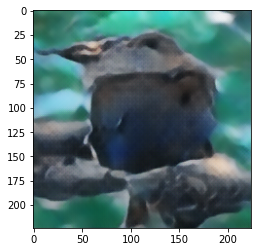

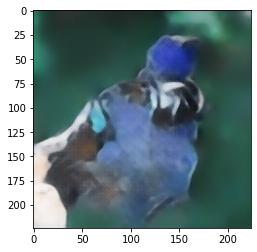

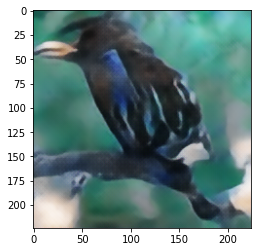

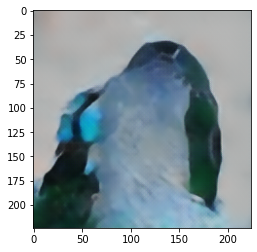

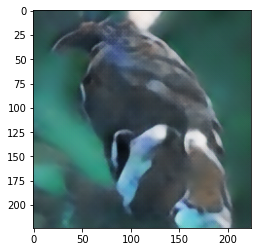

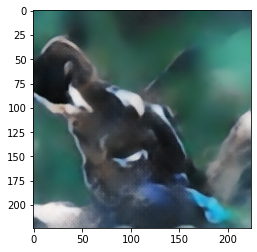

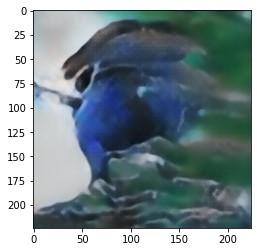

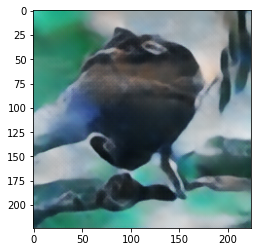

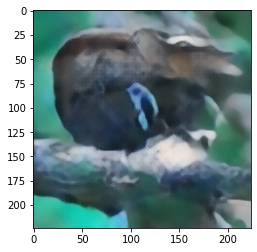

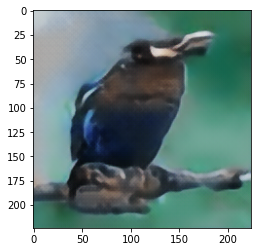

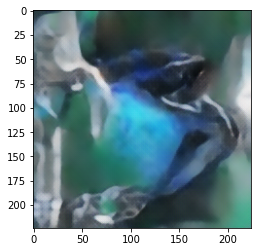

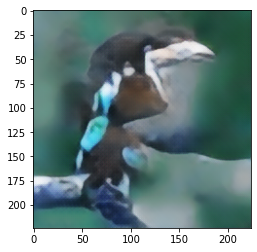

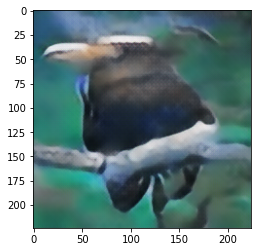

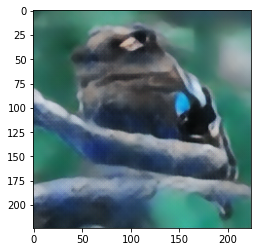

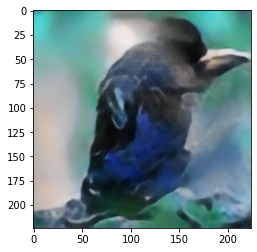

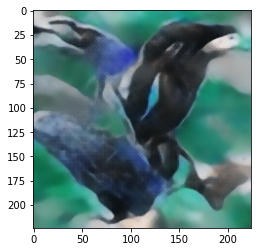

In [ ]:
classes = []
t = 1.2
for i in range(30):
  rep = trainer.generate(temp = t)
  classes.extend(rep)

In [ ]:
classes = [int(i) for i in classes]

In [ ]:
import collections
counter=collections.Counter(classes)
counter = dict(counter)
counter

In [ ]:
import seaborn as sns
sns.histplot(data=np.array(classes),bins=512)